In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import pandas as pd
import numpy as np
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [39]:
df = pd.read_excel('D:/Denoising/Autoencoder/LSTM_SAE/Gold.xlsx')
#df = df[-310:-60]
df = df[-250:]
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['종가']])
df["Close"] = scaled

In [2]:
# Data Load
paht = 'D:/Denoising/Autoencoder/LSTM_SAE/Samsung.txt'
def Data_Load(path):
    global df
    df = pd.read_csv(path, sep = ',')
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df[['CLOSE']])
    df["Close"] = scaled
    return df

In [23]:
def Slice_Window(size):
    global window_list, x_train, x_test, y_train, y_test
    window_list = np.zeros((len(df)-size+1,size,1))
    count = 0
    for i in range(len(df)-size+1):
        end_idx = i+size
        dff = df[i:end_idx]
        dff.reset_index(inplace = True)
        if len(dff)>=size:
            for j in range(size):
                window_list[count][j][0] = dff["Close"][j]            
            count += 1
    
    # Split Train and Test Set
    x_train, x_test, y_train, y_test = train_test_split(window_list, window_list, test_size=0.2, random_state=42)

In [24]:
def Build_Model():
    global model
    model = keras.Sequential()

    timestamp = window_list.shape[1]
    features = window_list.shape[2]

    # Encoder LSTM cell1
    model.add(keras.layers.LSTM(units=20, input_shape=(timestamp, features), return_sequences = True))
    model.add(keras.layers.Dropout(rate=0.2))

    # Encoder LSTM cell2
    model.add(keras.layers.LSTM(units=15, return_sequences=True))
    model.add(keras.layers.Dropout(rate=0.2))

    # Encoder LSTM cell3
    model.add(keras.layers.LSTM(units=10, return_sequences=False))
    model.add(keras.layers.Dropout(rate=0.2))

    model.add(keras.layers.RepeatVector(timestamp))

    # Decoder LSTM cell1
    model.add(keras.layers.LSTM(units=10, return_sequences=True))
    model.add(keras.layers.Dropout(rate=0.2))

    # Decoder LSTM cell2
    model.add(keras.layers.LSTM(units=15, return_sequences=True))
    model.add(keras.layers.Dropout(rate=0.2))

    # Decoder LSTM cell3
    model.add(keras.layers.LSTM(units=20, return_sequences=True))
    model.add(keras.layers.Dropout(rate=0.2))

    model.add(keras.layers.TimeDistributed(keras.layers.Dense(features)))
    model.compile(loss='mse', optimizer = Adam(learning_rate = 0.0001))

    return model.summary()

In [25]:
def Train(vb):
    global history
    if vb == 1:
        history = model.fit(x_train, y_train, epochs=500, batch_size=10,validation_split=0.1, verbose = 1, shuffle=True)
    else:
        history = model.fit(x_train, y_train, epochs=500, batch_size=10,validation_split=0.1, verbose = 0, shuffle=True)

In [26]:
def Output(show):
    global mean_list, mean_list2
    
    # Predict
    pred = model.predict(window_list)
    
    # Sum all window size units
    mean_list = [0 for i in range(len(df))]
    for i in range(len(window_list)):
        for j in range(20):
            mean_list[i+j] += pred[i][j]

    # Calculate average
    mean_list2= []
    count = 19
    for i in range(len(mean_list)):
        if i < 20:
            mean_list2.append(mean_list[i] / (i+1))
        elif i >=20 and (i <= len(mean_list)-20):
            mean_list2.append(mean_list[i] / 20)
        else:
            mean_list2.append(mean_list[i] / count)
            count -= 1

    # If value is equal 1, then Show the plot
    if show == 1:
        price = list(df["Close"])
        plt.figure(figsize = (15,10))
        plt.plot(mean_list2, label = 'denoised')
        plt.plot(price, label = 'origin')
        plt.grid()
        plt.legend(loc ='upper right')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.show()
    else:
        print('Complete')

In [27]:
# Check Output MAE
def Check_MAE():
    global total_mae, total_mae2
    total_mae = 0
    total_mae2 = 0
    price = list(df["Close"])
    for i in range(len(mean_list2)):
        mae = np.abs(price[i] - mean_list2[i])
        total_mae += mae
    total_mae2 = total_mae / len(mean_list2)*100
    return total_mae2

In [8]:
Data_Load()

,MARKET,NAME,SYMBOL,DATEDEAL,OPEN,HIGH,LOW,CLOSE,DIFF,VOLUME,Close
0,KOSPI,삼성전자,5930,2016-01-04,25200,25200,24100,24100,-4.37,306939,0.023072
1,KOSPI,삼성전자,5930,2016-01-05,24040,24360,23720,24160,0.25,216002,0.023949
2,KOSPI,삼성전자,5930,2016-01-06,24160,24160,23360,23500,-2.73,366752,0.014311
3,KOSPI,삼성전자,5930,2016-01-07,23320,23660,23020,23260,-1.02,282388,0.010806
4,KOSPI,삼성전자,5930,2016-01-08,23260,23720,23260,23420,0.69,257763,0.013143
...,...,...,...,...,...,...,...,...,...,...,...
1470,KOSPI,삼성전자,5930,2021-12-24,80200,80800,80200,80500,0.75,12086380,0.846671
1471,KOSPI,삼성전자,5930,2021-12-27,80600,80600,79800,80200,-0.37,10783368,0.842290
1472,KOSPI,삼성전자,5930,2021-12-28,80200,80400,79700,80300,0.12,18226325,0.843750
1473,KOSPI,삼성전자,5930,2021-12-29,80200,80200,78500,78800,-1.87,19794795,0.821846


In [35]:
Slice_Window(20)
Build_Model()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 20, 20)            1760      
                                                                 
 dropout_12 (Dropout)        (None, 20, 20)            0         
                                                                 
 lstm_13 (LSTM)              (None, 20, 15)            2160      
                                                                 
 dropout_13 (Dropout)        (None, 20, 15)            0         
                                                                 
 lstm_14 (LSTM)              (None, 10)                1040      
                                                                 
 dropout_14 (Dropout)        (None, 10)                0         
                                                                 
 repeat_vector_2 (RepeatVect  (None, 20, 10)          

In [36]:
# Check how much the predicted value changes when the same model and the same data are used.

# Attempt several model training
MAE_list = []
for i in range(0,10):
    Train(0)
    Output(0)
    MAE_list.append(Check_MAE())

8/8 [==============================] - 6s 12ms/step
Complete
8/8 [==============================] - 2s 6ms/step
Complete
8/8 [==============================] - 2s 8ms/step
Complete
8/8 [==============================] - 2s 7ms/step
Complete
8/8 [==============================] - 2s 8ms/step
Complete
8/8 [==============================] - 2s 8ms/step
Complete
8/8 [==============================] - 2s 6ms/step
Complete
8/8 [==============================] - 2s 7ms/step
Complete
8/8 [==============================] - 2s 7ms/step
Complete
8/8 [==============================] - 2s 6ms/step
Complete


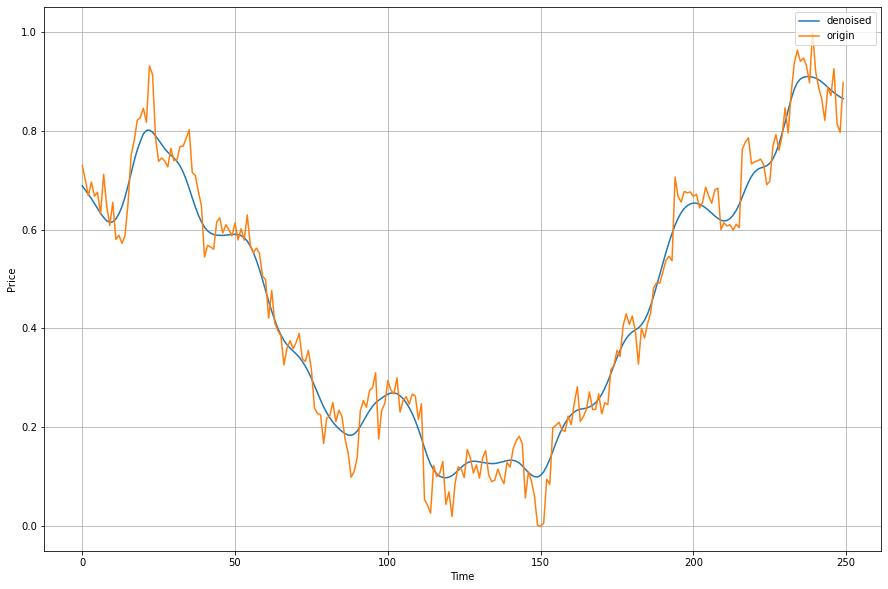

In [37]:
price = list(df["Close"])
plt.figure(figsize = (15,10))
plt.plot(mean_list2, label = 'denoised')
plt.plot(price, label = 'origin')
plt.grid()
plt.legend(loc ='upper right')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

In [43]:
save_file = open("D:\\Denoising\\Autoencoder\\LSTM_SAE\\gold_recent.txt", "a")
for i in range(len(mean_list2)):
    save_file.write(str(mean_list2[i])+"\n")
save_file.close()